## Librerias

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
ran =62

In [3]:
df = pd.read_feather('../data/preprocessed_data.feather')

In [4]:
df_model = df.copy()

In [5]:
df_model = df_model.drop(['id', 'neighbourhood'], axis=1)

In [6]:
df_model.head()

,fixed_price,stratum,bathrooms,age,rooms,Acceso Pavimentado,Aire Acondicionado,Alarma,Alarma Contra Incendio,Alcantarillado,...,Zona Industrial,Zona Infantil,Zona Residencial,Zona de BBQ,Zona de Camping,Zona de lavandería,Zonas Verdes,Árboles frutales,Área Urbana,total_area
0,6.100000e+08,3.0,3.0,> 30,4.0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,181.0
1,3.200000e+08,3.0,3.0,9 - 15,4.0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,120.0
2,1.190000e+09,6.0,4.0,9 - 15,3.0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,263.0
3,5.850000e+08,3.0,2.0,> 30,3.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,120.0
4,1.400000e+09,5.0,3.0,16 - 30,7.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,248.0


In [7]:
temp_dict_age = {
    '< 1'       : 1,
    '1 - 8'     : 2,
    '9 - 15'    : 3, 
    '16 - 30'   : 4, 
    '> 30'      : 5, 
    'ND'        : 0,    
}

In [8]:
df_model['age'] = df_model['age'].map(temp_dict_age)

In [9]:
df_model['fixed_price'].sort_values(ascending=False)

169    3.300000e+11
875    2.656000e+11
156    1.300000e+10
769    1.200000e+10
866    8.500000e+09
           ...     
225    1.380000e+08
430    1.380000e+08
486    1.290000e+08
919    1.200000e+08
674    1.130000e+08
Name: fixed_price, Length: 977, dtype: float64

### Datasets

MODIFICACIONES A LOS DATOS
- Escalado de los datos
- Remover caracteristicas
- Escalado del target
- Separacion de las variables estrato, age en variables dummies
- Análisis de anomalias

In [10]:
df_model['fixed_price'] = df_model['fixed_price']/1000000 # Precios en cientos de millones de pesos
df_model['fixed_price'].sort_values(ascending=False)

169    330000.0
875    265600.0
156     13000.0
769     12000.0
866      8500.0
         ...   
225       138.0
430       138.0
486       129.0
919       120.0
674       113.0
Name: fixed_price, Length: 977, dtype: float64

- Existen datos demasiado grandes para el precio de una vivienda teniendo en cuenta los precios de las otras viviendas. Al analizar dicha vivienda sus caracteristicas son bastante regulares por lo que se cree puede ser un error y se filtran.

### Restricción de precios

Analisis de anomalias sobre las casa con precios muy altos y que no representan el conjunto de datos completamente

In [11]:
df_model = df_model[df_model['fixed_price'] <= 6000] #6000

#### Separación del dataframe

In [12]:
def features_target_split(df):
    features = df.drop('fixed_price', axis=1)
    target = df['fixed_price']
    return features, target

In [13]:
df_train, df_pass = train_test_split(df_model, test_size=0.3, random_state=ran)
df_valid, df_test = train_test_split(df_pass, test_size=0.5, random_state=ran)

#### Isolation Forest

In [14]:
features_isolation_array = ['stratum',	'bathrooms','age','rooms', 'total_area']
features_isolation_train = df_train.copy()[features_isolation_array]
clf_forest = IsolationForest(max_samples=100, 
                             max_features=0.9,
                             n_estimators=50,
                             contamination=0.1, # funciona 0.05
                             random_state=ran)
clf_forest.fit(features_isolation_train)

IsolationForest(contamination=0.1, max_features=0.9, max_samples=100,
                n_estimators=50, random_state=62)

In [15]:
def scatterplot_one(df):
    plt.figure(figsize=(15,6))
    sns.scatterplot(df,  
                    x='total_area',
                    y='fixed_price',
                    hue='is_anomaly', 
                    # size='rooms',
                    palette="deep"
                    )
    plt.show()
def pairplot_one(df):
    sns.pairplot(df[['fixed_price','stratum',	'bathrooms','age','rooms', 'total_area', 'is_anomaly']], hue='is_anomaly', palette='magma')
    plt.show()

In [16]:

def anomalies_transformation(df, classificator, has_print=False):
    df_new = df.copy()
    anomalies_detected = classificator.predict(df_new[features_isolation_array])
    df_new['is_anomaly'] = anomalies_detected
    df_new['is_anomaly'] = df_new['is_anomaly'].apply(lambda x: 0 if x == 1 else 1)
    
    print('Total anomalies:' , len(df_new.query('is_anomaly == 1')))
    
    if has_print:
        scatterplot_one(df_new)
        pairplot_one(df_new)
    
    return df_new.query('is_anomaly == 0').drop('is_anomaly', axis=1)

Total anomalies: 16
Total anomalies: 18
Total anomalies: 68


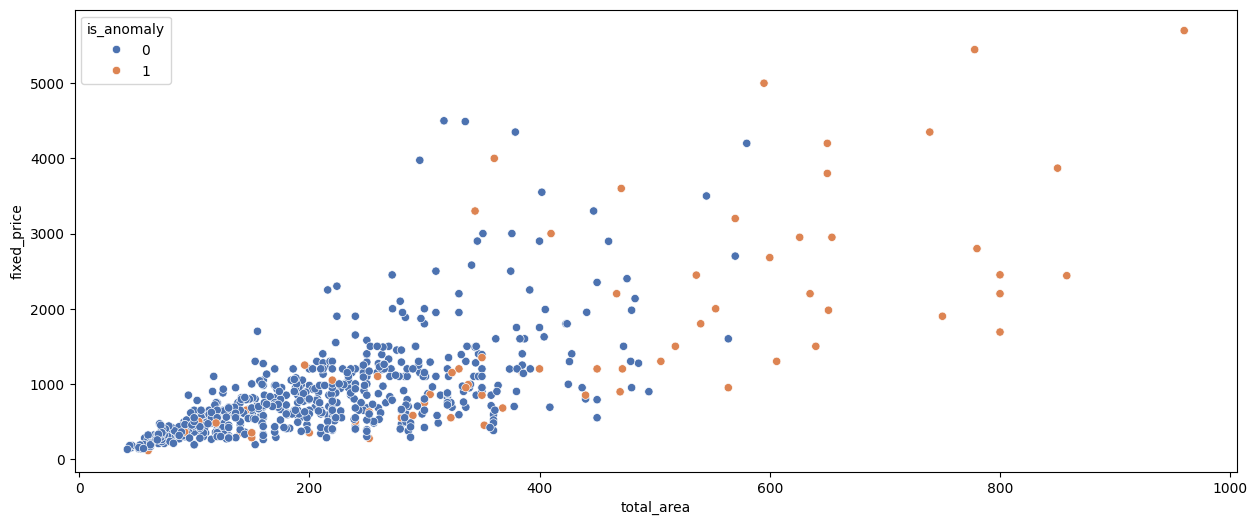

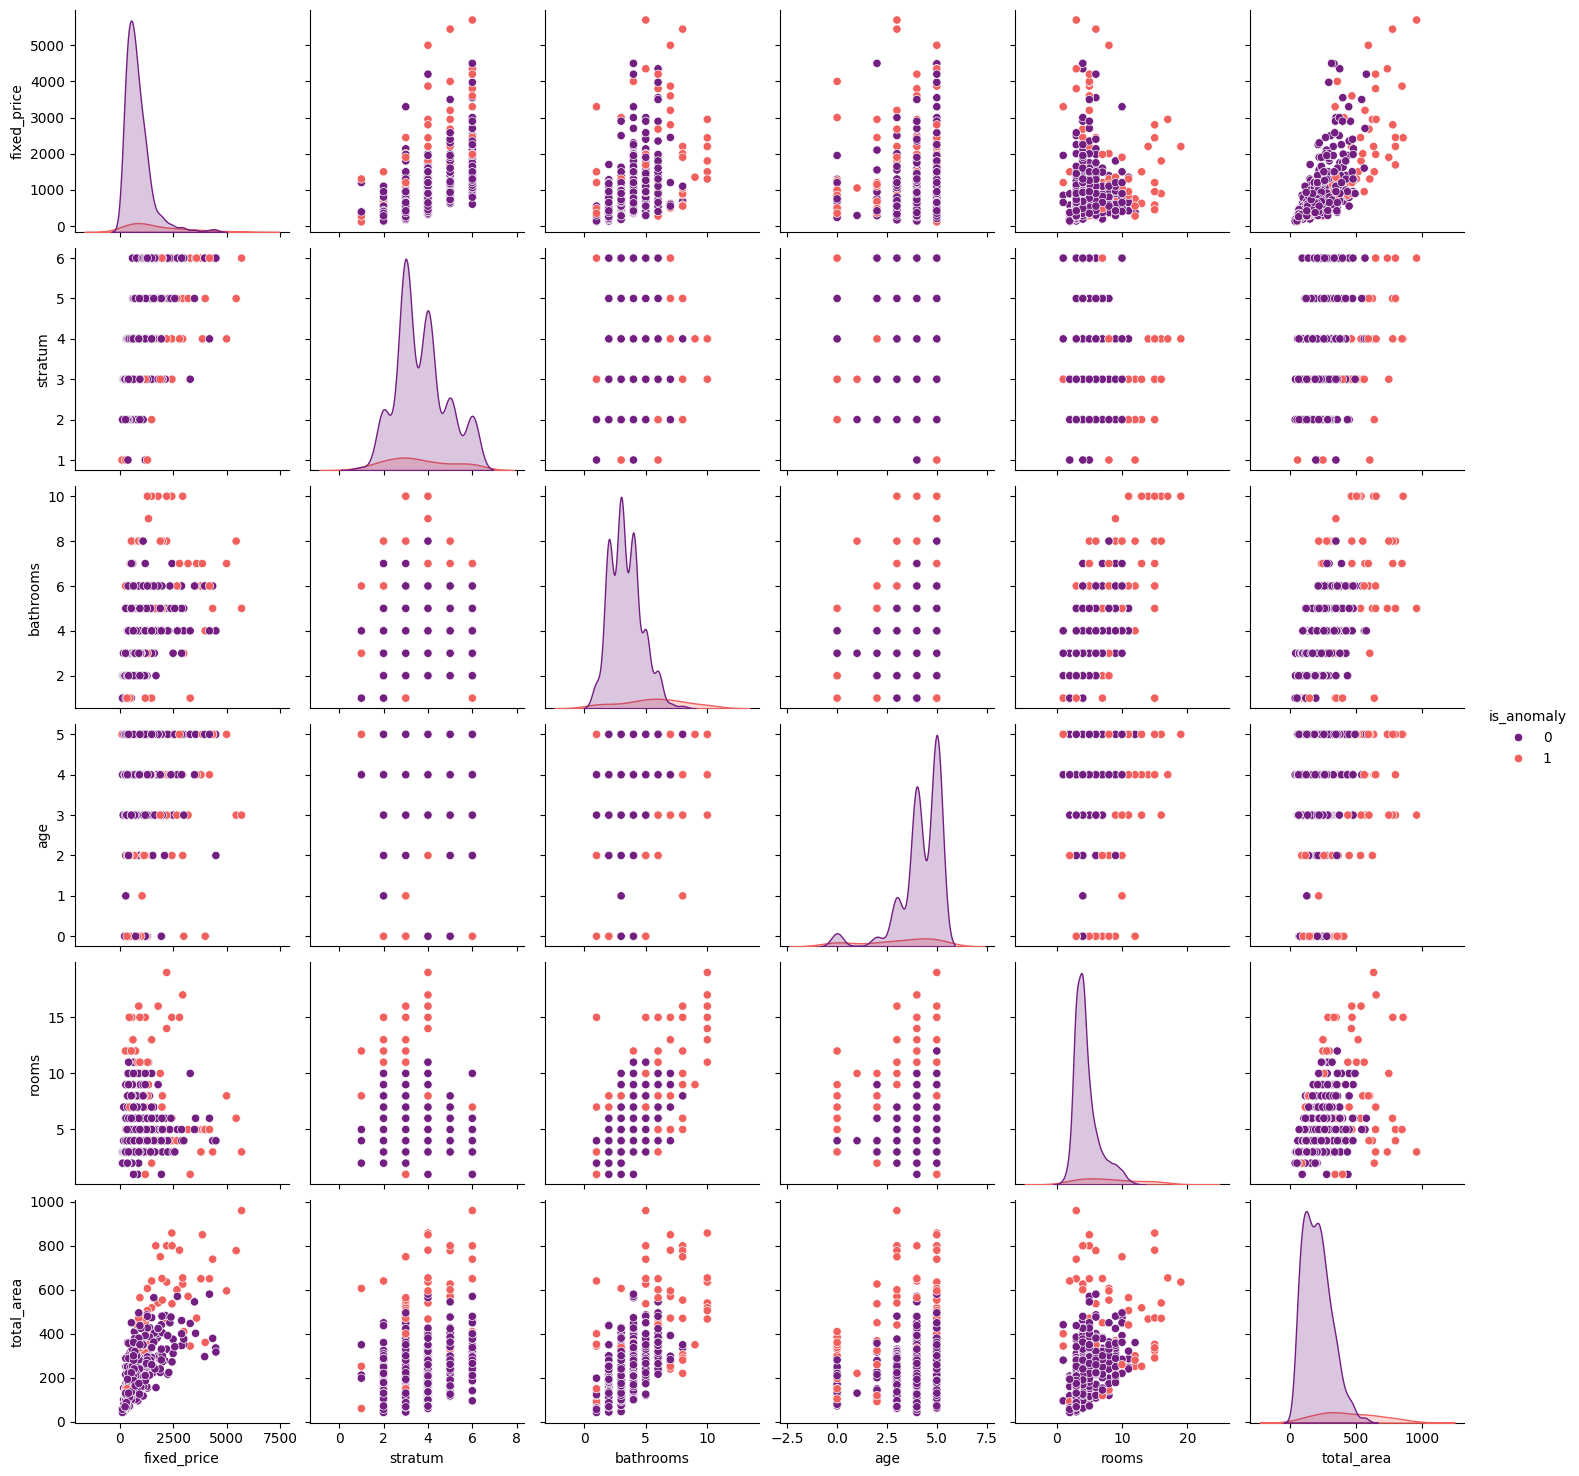

In [17]:
df_valid_isolation = anomalies_transformation(df_valid, clf_forest)
df_test_isolation = anomalies_transformation(df_test, clf_forest)
df_train_isolation = anomalies_transformation(df_train, clf_forest, True)

- Se aislan los datos basados en el isolation forest que se consideran atipicos por sus características. 
- Los datos con precion fijo mayor a 6000 también se aislan puesto que visiblemente estan alejados de los datos principales.

#### DBSCAN clustering

In [18]:
clustering = DBSCAN(eps=7,
                    min_samples=13,
                    # random_state=ran
                    )
clustering.fit_predict(features_isolation_train)
df_cluster = df_train.copy()
predictions = clustering.labels_
df_cluster['is_anomaly'] = predictions

In [19]:
df_cluster['is_anomaly'].value_counts()

is_anomaly
 0    523
-1     74
 1     36
 2     17
 4     13
 3     13
Name: count, dtype: int64

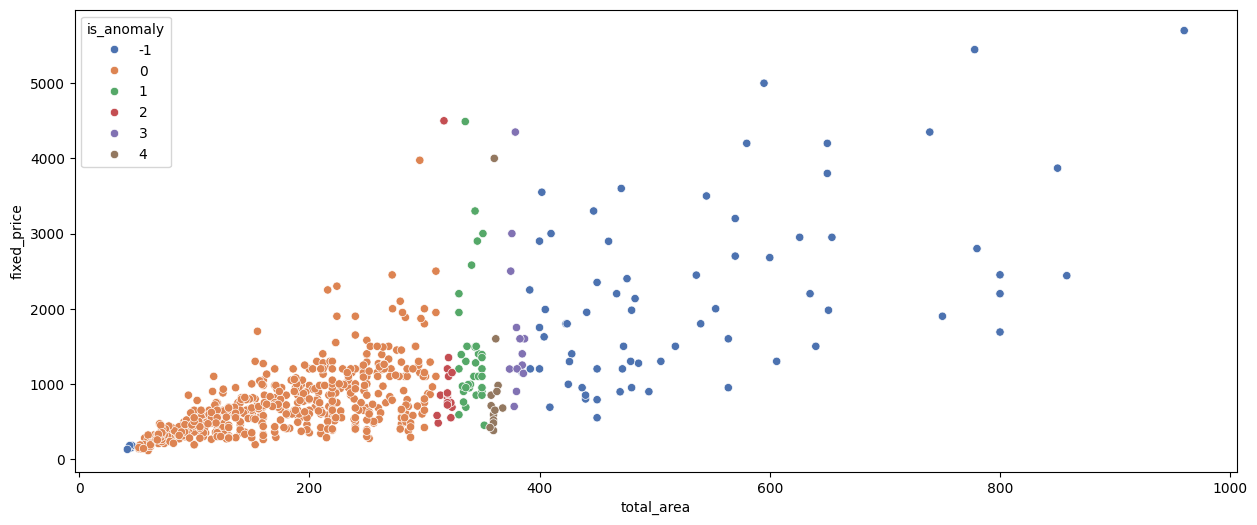

In [20]:
scatterplot_one(df_cluster)

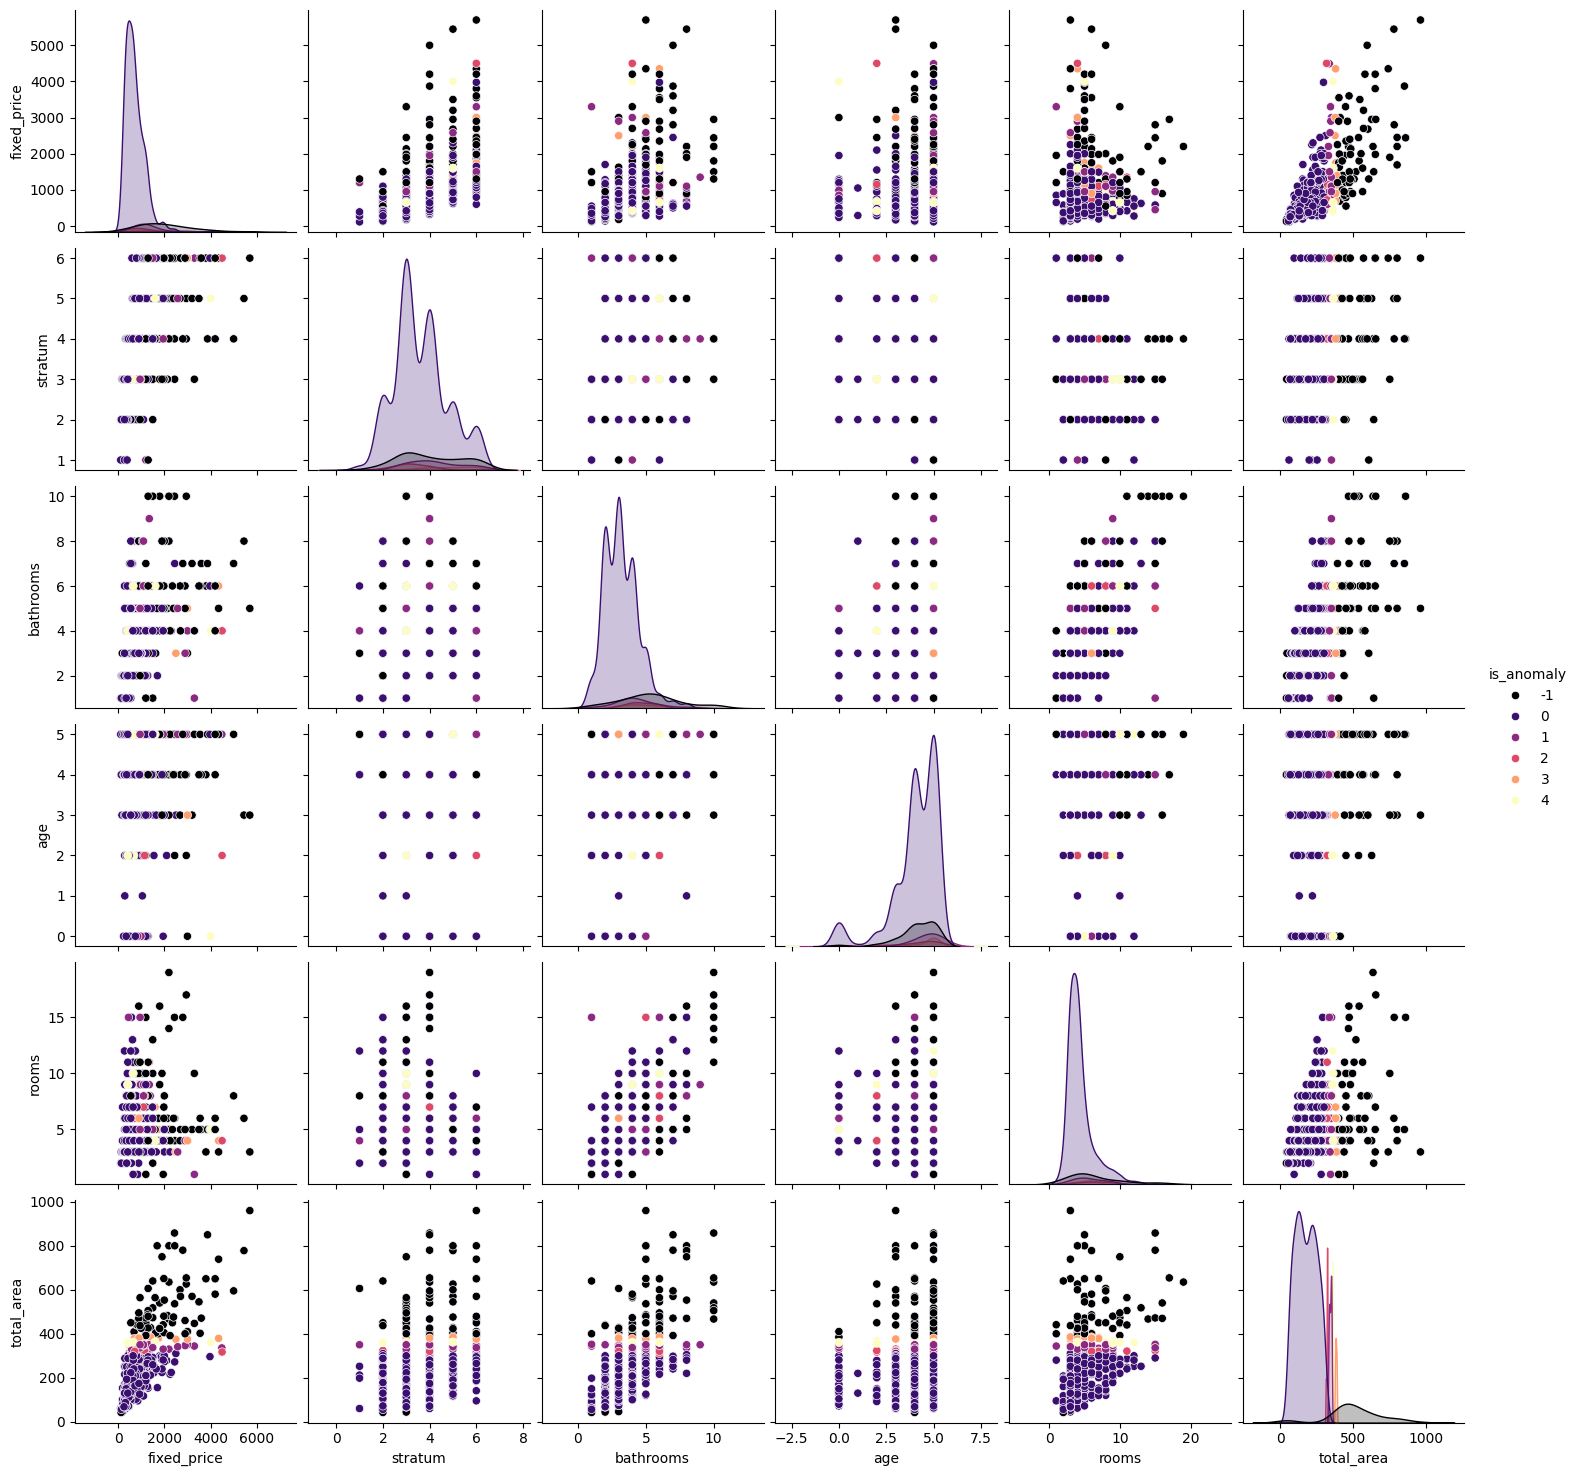

In [21]:
pairplot_one(df_cluster)

- Basado en los cortes observados por el metodo de clustering se decide realizar un datasetet que se adapte solo a las áreas menores a 400m2

In [22]:
df_train_cluster = df_train.copy()
df_train_cluster = df_train_cluster.query('total_area <= 400')
df_valid_cluster = df_valid.copy().query('total_area<=400')

#### Local Outlier Factor

In [23]:
clf_lof = LocalOutlierFactor(n_neighbors=5,
                             algorithm='kd_tree',
                            #  leaf_size=2
                            contamination=0.1
                             )

In [24]:
predict_lof = clf_lof.fit_predict(features_isolation_train)
df_lof = df_train.copy()
df_lof['is_anomaly'] = predict_lof

In [25]:
df_lof['is_anomaly'].value_counts()

is_anomaly
 1    608
-1     68
Name: count, dtype: int64

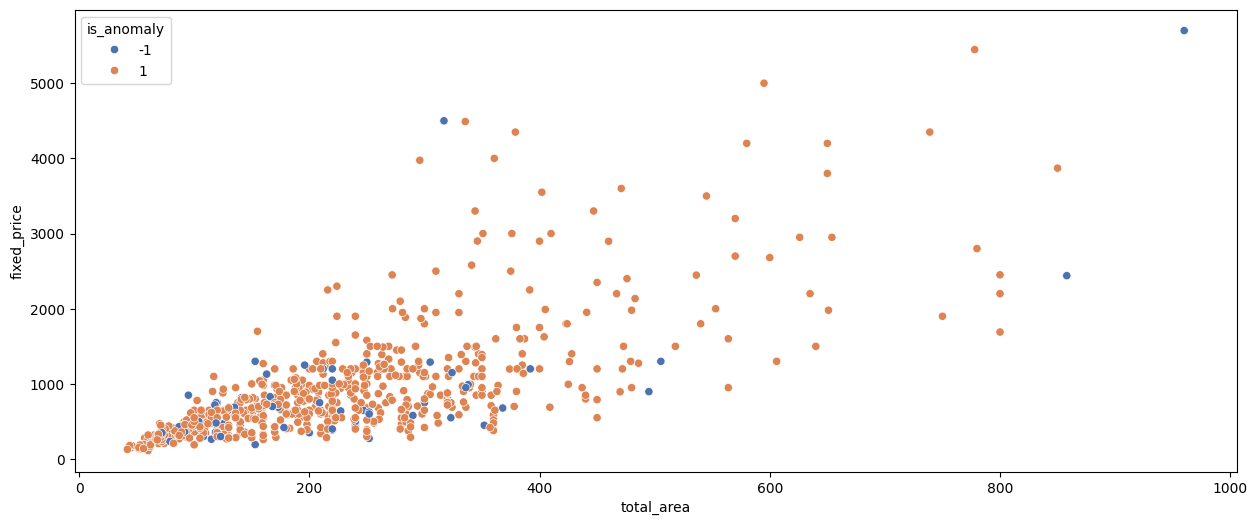

In [26]:
scatterplot_one(df_lof)

#### Escalado de variables

In [27]:
scaler = RobustScaler()
# Escalar todo
scaler.fit(df_train.drop('fixed_price', axis=1))   
df_train_scaled = df_train.copy()

In [28]:
def scaler_transformation(df, scaler):
    df_new = df.copy()
    features_df = df_new.drop('fixed_price', axis=1)
    df_new = pd.DataFrame(scaler.transform(features_df), 
                          columns=features_df.columns,
                          index=features_df.index)
    df_new['fixed_price'] = df['fixed_price']
    return df_new

In [29]:
df_train_scaled = scaler_transformation(df_train, scaler)
df_valid_scaled = scaler_transformation(df_valid, scaler)

#### Selección de características

In [30]:
model_forest_selection = RandomForestRegressor(n_estimators=100,random_state=ran)
features_selection_train, target_selection_train = features_target_split(df_train)
model_forest_selection.fit(features_selection_train, target_selection_train)

data_impotances = {'importances' : model_forest_selection.feature_importances_,
'names' : model_forest_selection.feature_names_in_}
df_importances = pd.DataFrame(data_impotances, columns=['names', 'importances'], )\
                        .sort_values(by='importances', ascending=False)\
                        .reset_index(drop=True)

In [31]:
most_important_features_20 = list(df_importances.loc[0:20,'names'])

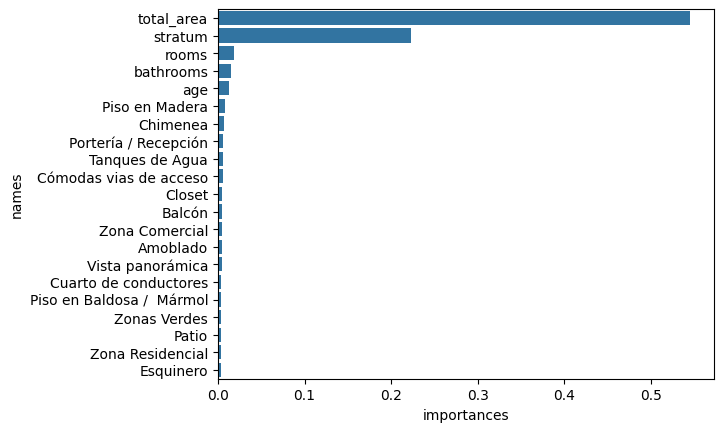

In [32]:
sns.barplot(df_importances.loc[0:20,:], x='importances', y='names')
plt.show()

In [33]:
most_important_features_20.append('fixed_price')

In [34]:
def remove_features_df(df, list_important=most_important_features_20 ):
    df_new = df.copy()
    df_new = df_new[list_important]
    return df_new

In [35]:
df_train_selected_features = remove_features_df(df_train)
df_valid_selected_features = remove_features_df(df_valid)
df_test_selected_features = remove_features_df(df_test)

#### OHE

In [36]:
def ohe_transform(df):
    new_df = df.copy()
    ohe_features = new_df['stratum']
    ohe_features = pd.get_dummies(ohe_features, drop_first=True, dtype=int)
    ohe_features.columns = ['2','3', '4', '5', '6']
    new_df = new_df.drop('stratum', axis=1)
    new_df = pd.concat([new_df, ohe_features], axis=1)
    return new_df

In [37]:
def ohe_transform_valid(df):
    new_df = df.copy()
    ohe_features = new_df['stratum']
    ohe_features = pd.get_dummies(ohe_features, drop_first=True, dtype=int)
    ohe_features.columns = ['3', '4', '5', '6']
    new_df = new_df.drop('stratum', axis=1)
    new_df['2'] = np.full(len(new_df), 0)
    new_df = pd.concat([new_df, ohe_features], axis=1)
    return new_df

In [38]:
df_train_ohe = ohe_transform(df_train_selected_features)
df_valid_ohe = ohe_transform_valid(df_valid_selected_features)

#### Caracteristicas nuevas

In [39]:
def create_new_features(df):
    f_df = df.copy()
    f_df['area_per_room'] = f_df['total_area'] / f_df['rooms']
    f_df['area_per_bathroom'] = f_df['total_area'] / f_df['bathrooms']
    f_df['area_per_stratum'] = f_df['total_area'] / f_df['stratum']
    f_df['stratum per_rooms'] = f_df['stratum'] / f_df['rooms']
    f_df['age_inverted'] = 1/ ( f_df['age'] +1)
    
    total_columns = list(f_df.columns)
    columns_to_delete = ['total_area','stratum', 'rooms', 'bathrooms','age', 'fixed_price']
    total_amenities = [i for i in total_columns if i not in columns_to_delete]    
    f_df['total_amenities'] = f_df[total_amenities].sum(axis=1)
    
    return f_df

In [40]:
df_train_new_features = create_new_features(df_train)
df_valid_new_features = create_new_features(df_valid)
df_test_new_features = create_new_features(df_test)
list_new_features = ['total_area','stratum', 'rooms', 'bathrooms','age', 'fixed_price','area_per_room','area_per_bathroom','area_per_stratum','stratum per_rooms','age_inverted','total_amenities' ]
df_train_new_features_removed = remove_features_df(df_train_new_features, list_new_features)
df_valid_new_features_removed = remove_features_df(df_valid_new_features, list_new_features)
df_test_new_features_removed = remove_features_df(df_test_new_features, list_new_features)

## Modelos

#### Funciones

In [41]:
def metrics_eval(target, predictions, dataset_name):
    rmse = root_mean_squared_error(target, predictions)
    mae = mean_absolute_error(target, predictions)
    print(f'Dataset de {dataset_name}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')

In [42]:
def graph_predictions_each_data(target, predictions):
    plt.figure(figsize=(15,6))
    arary_length = np.arange(len(target))
    plt.scatter(arary_length, predictions, marker='*', label='Predictions', s=20, alpha=0.8)
    plt.scatter(arary_length, target, label='Real values', s=20, alpha=0.8)
    plt.title('Price of the observation')
    plt.xlabel('Data number')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [43]:
def graph_predictions(target, predictions, ax, title):
    ax.scatter(target, predictions, s=20, alpha=0.8)
    ax.plot([target.min(), target.max()], [target.min(), target.max()], 'r--')
    ax.set_title(title)
    ax.set_xlabel('Valor real')
    ax.set_ylabel('Predicción')
    ax.legend(['Predicciones', 'Línea ideal'])

In [44]:
def model_evaluation(model, df_train, df_valid, model_name):

    f_train, t_train = features_target_split(df_train)
    f_valid, t_valid = features_target_split(df_valid)

    model.fit(f_train, t_train)
    predictions_t = model.predict(f_train)
    predictions_v = model.predict(f_valid)

    print(f"📊 Evaluación del modelo: {model_name}")
    metrics_eval(t_train, predictions_t, 'Entrenamiento')
    metrics_eval(t_valid, predictions_v, 'Validación')

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    graph_predictions(t_train, predictions_t, axs[0], 'Entrenamiento')
    graph_predictions(t_valid, predictions_v, axs[1], 'Validación')

    fig.suptitle(f'Comparación de Predicciones - {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

### Regresión lineal

📊 Evaluación del modelo: Regresión Lineal
Dataset de Entrenamiento
RMSE: 350.26
MAE: 226.50
Dataset de Validación
RMSE: 603.83
MAE: 365.92


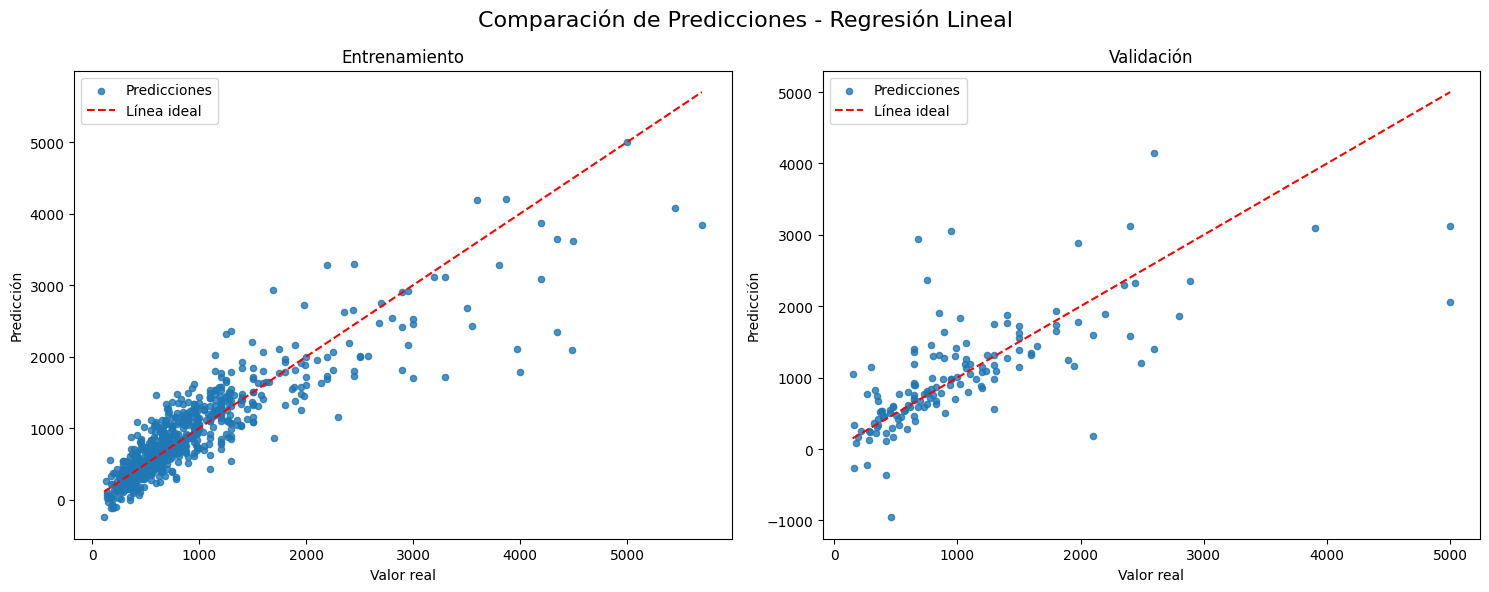

In [45]:
model_linear = LinearRegression()
model_evaluation(model_linear, df_train, df_valid, 'Regresión Lineal')

📊 Evaluación del modelo: Regresión Lineal - Aislado
Dataset de Entrenamiento
RMSE: 300.07
MAE: 192.50
Dataset de Validación
RMSE: 586.67
MAE: 365.43


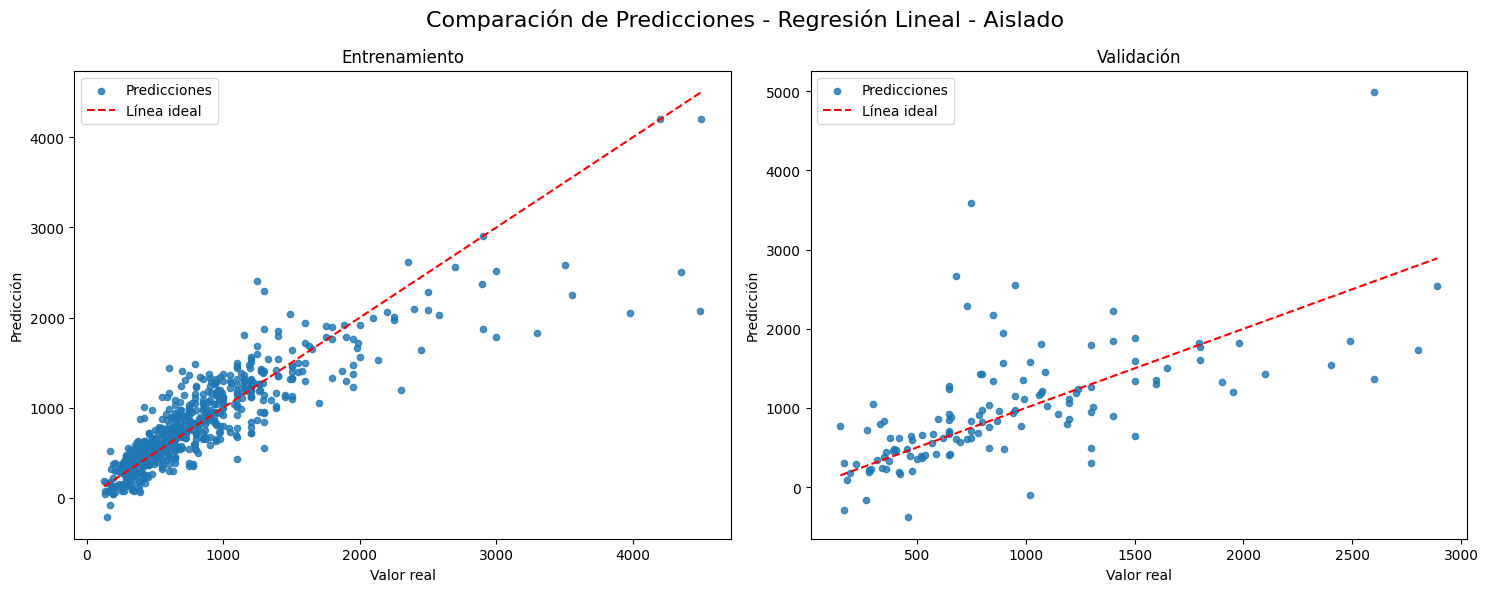

In [46]:
model_evaluation(model_linear, df_train_isolation, df_valid_isolation, 'Regresión Lineal - Aislado')

📊 Evaluación del modelo: Regresión Lineal - DF escalado
Dataset de Entrenamiento
RMSE: 350.26
MAE: 226.50
Dataset de Validación
RMSE: 603.83
MAE: 365.92


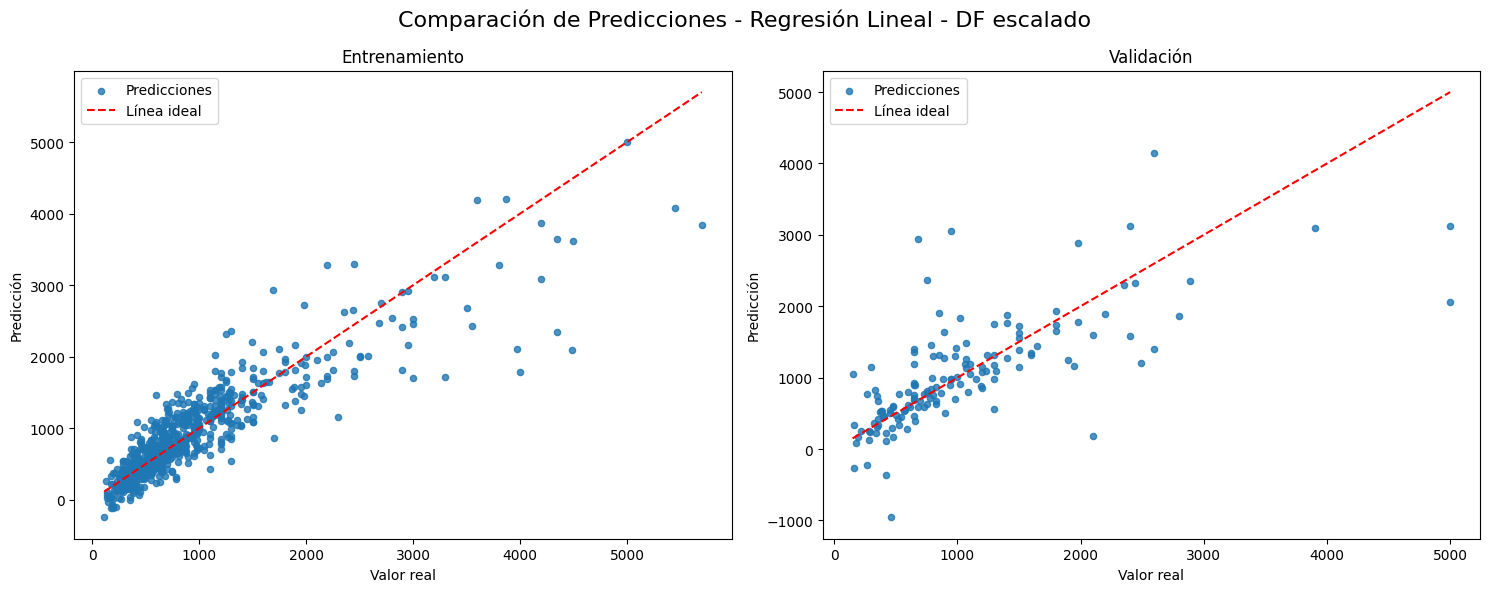

In [47]:
model_evaluation(model_linear, df_train_scaled, df_valid_scaled, 'Regresión Lineal - DF escalado')

📊 Evaluación del modelo: Linear model - Selected features
Dataset de Entrenamiento
RMSE: 412.92
MAE: 264.38
Dataset de Validación
RMSE: 467.67
MAE: 277.00


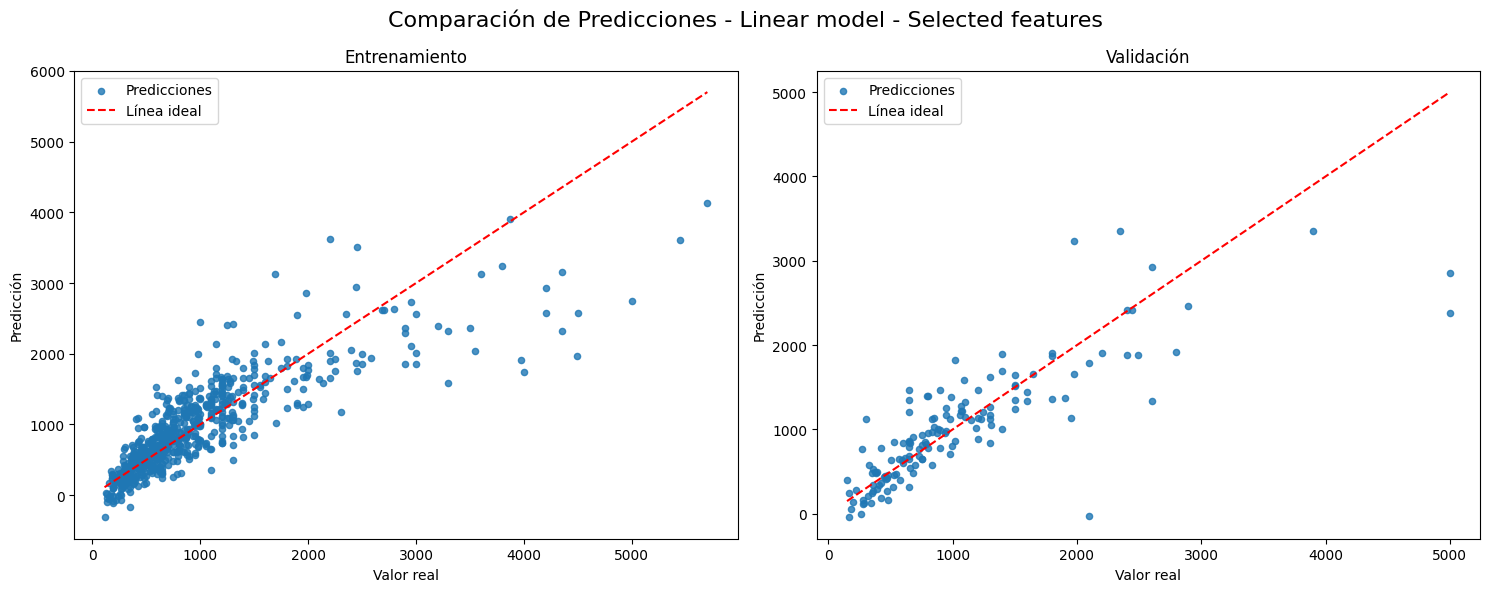

In [48]:
model_evaluation(model_linear, df_train_selected_features, df_valid_selected_features, 'Linear model - Selected features')

📊 Evaluación del modelo: Regresión Lineal - OHE stratum
Dataset de Entrenamiento
RMSE: 408.87
MAE: 258.30
Dataset de Validación
RMSE: 462.23
MAE: 271.43


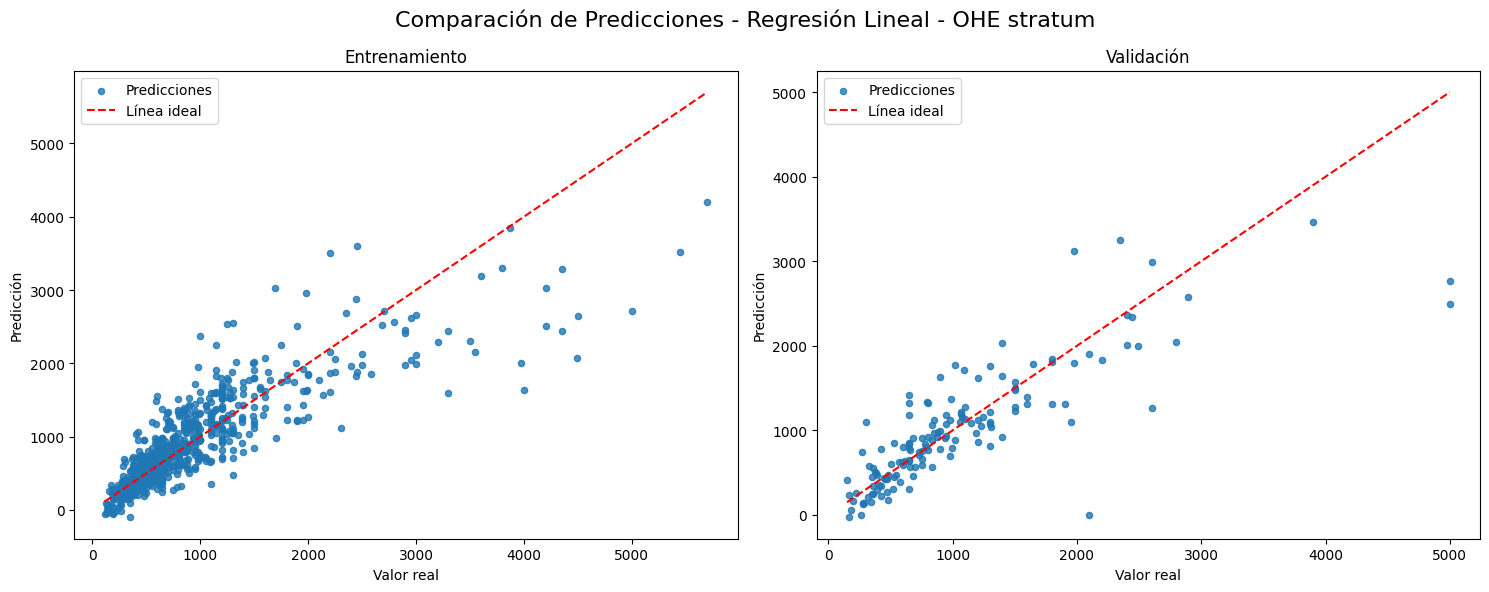

In [49]:
model_evaluation(model_linear, df_train_ohe, df_valid_ohe, 'Regresión Lineal - OHE stratum')

📊 Evaluación del modelo: Regresión Lineal - Nuevas caracteristicas
Dataset de Entrenamiento
RMSE: 346.23
MAE: 222.85
Dataset de Validación
RMSE: 601.31
MAE: 364.52


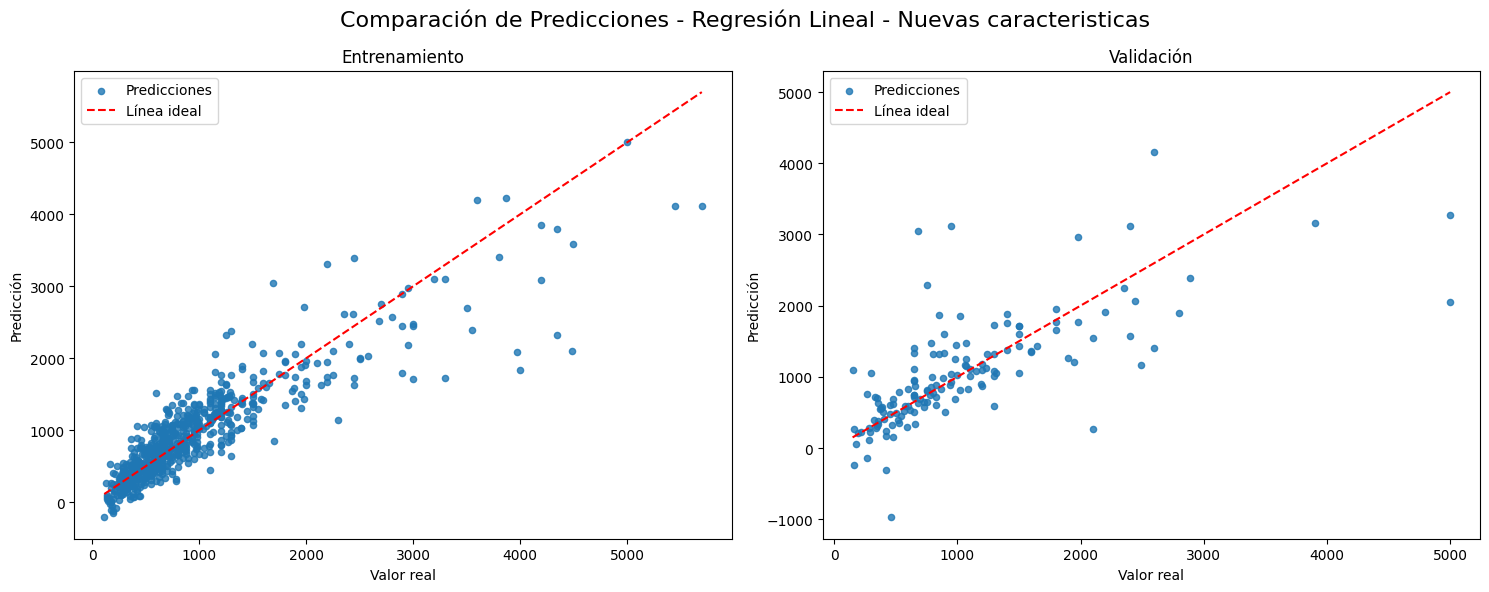

In [50]:
model_evaluation(model_linear, df_train_new_features, df_valid_new_features, 'Regresión Lineal - Nuevas caracteristicas')

### Random Forest

In [51]:
model_forest = RandomForestRegressor(n_estimators=50,
                                     max_depth=20,
                                     max_features=0.9,
                                     min_samples_split=10,
                                     random_state=ran)

📊 Evaluación del modelo: Random Forest
Dataset de Entrenamiento
RMSE: 265.66
MAE: 142.68
Dataset de Validación
RMSE: 410.70
MAE: 242.76


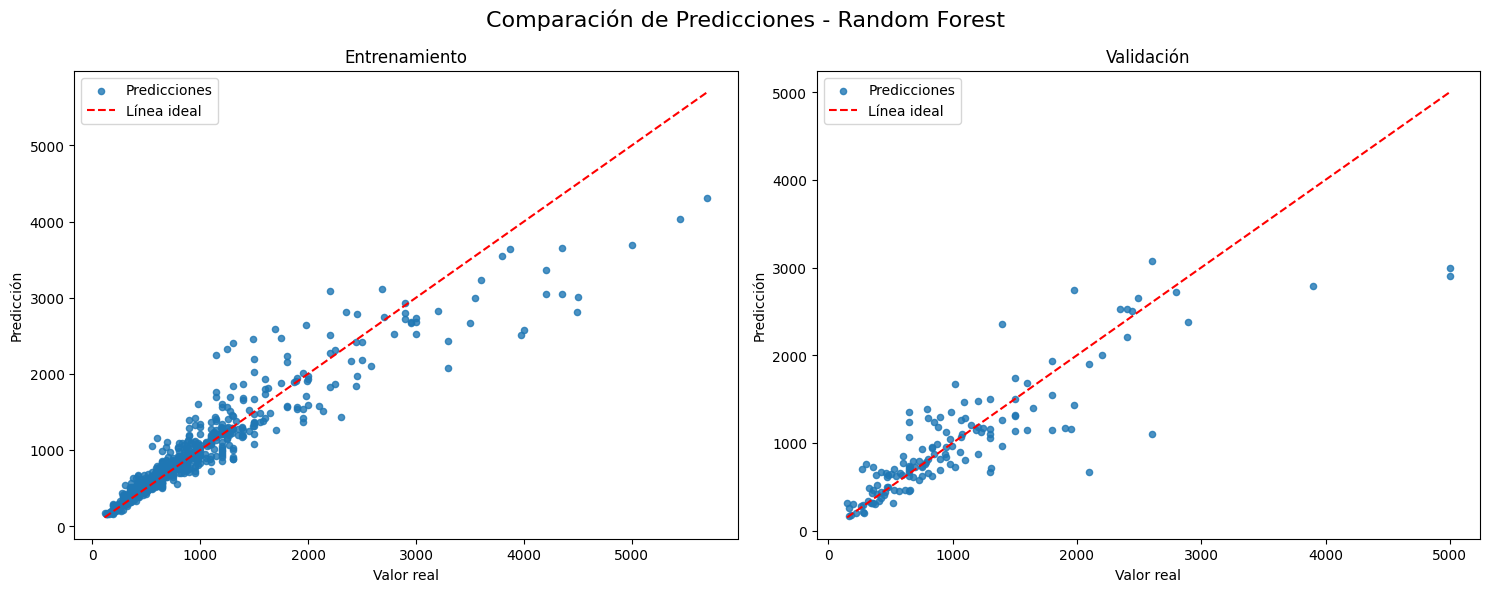

In [52]:
model_evaluation(model_forest, df_train, df_valid, 'Random Forest')

📊 Evaluación del modelo: Random Forest - Isolation
Dataset de Entrenamiento
RMSE: 233.73
MAE: 124.92
Dataset de Validación
RMSE: 297.94
MAE: 193.18


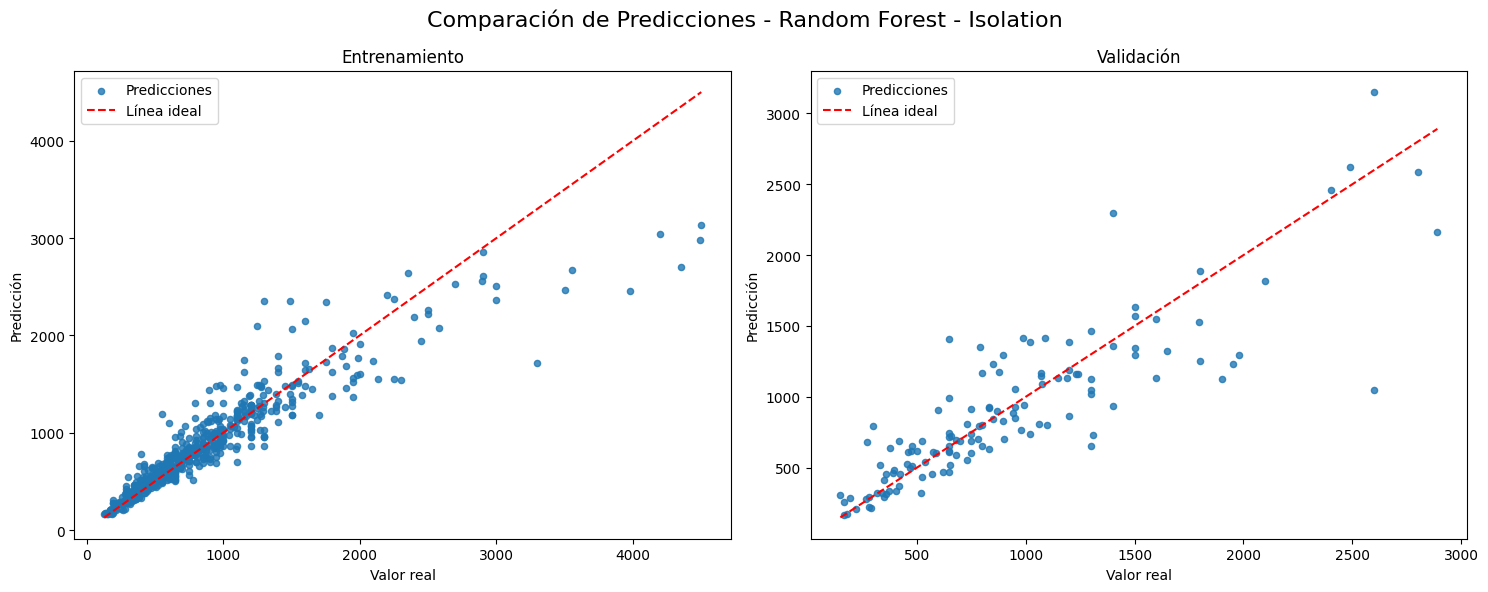

In [53]:
model_evaluation(model_forest, df_train_isolation, df_valid_isolation, 'Random Forest - Isolation')

📊 Evaluación del modelo: Random Forest - Escalado
Dataset de Entrenamiento
RMSE: 265.71
MAE: 142.77
Dataset de Validación
RMSE: 410.64
MAE: 242.56


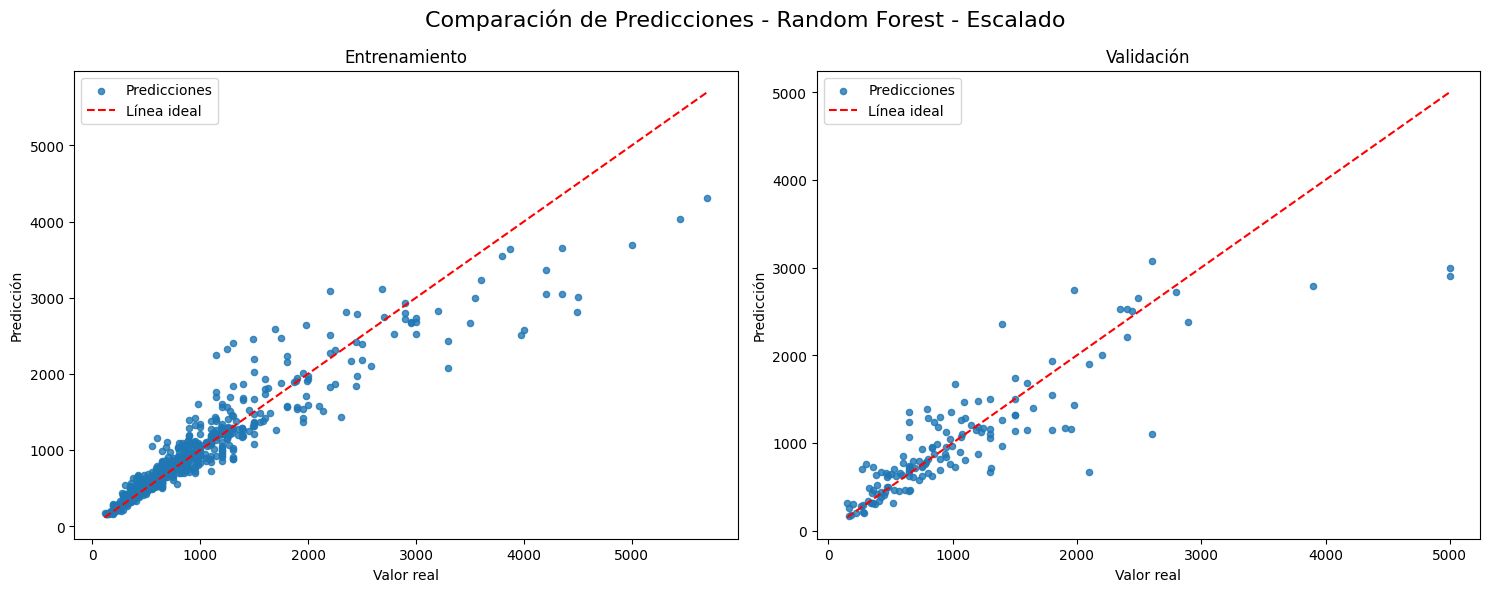

In [54]:
model_evaluation(model_forest, df_train_scaled, df_valid_scaled, 'Random Forest - Escalado')

📊 Evaluación del modelo: Random Forest - Selected features
Dataset de Entrenamiento
RMSE: 276.27
MAE: 152.39
Dataset de Validación
RMSE: 401.12
MAE: 236.62


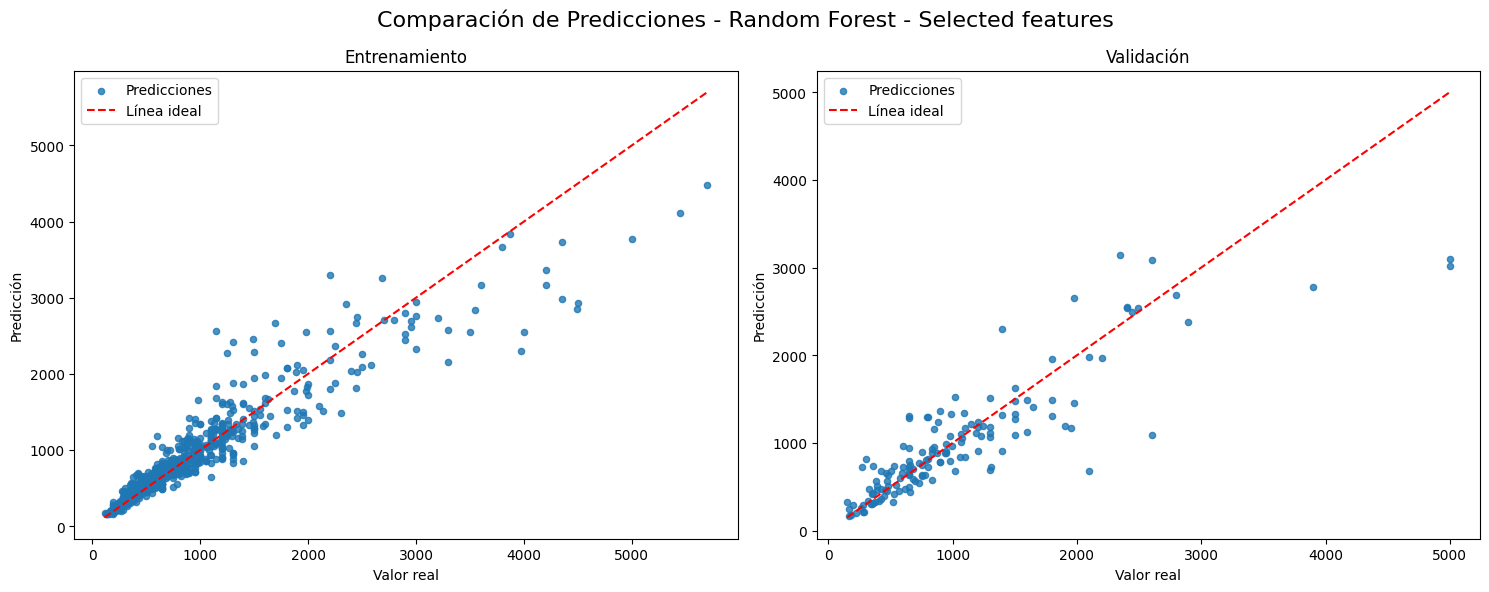

In [55]:
model_evaluation(model_forest, df_train_selected_features, df_valid_selected_features, 'Random Forest - Selected features')

📊 Evaluación del modelo: Random Forest - Nuevas caracteristicas
Dataset de Entrenamiento
RMSE: 257.21
MAE: 138.83
Dataset de Validación
RMSE: 409.88
MAE: 237.63


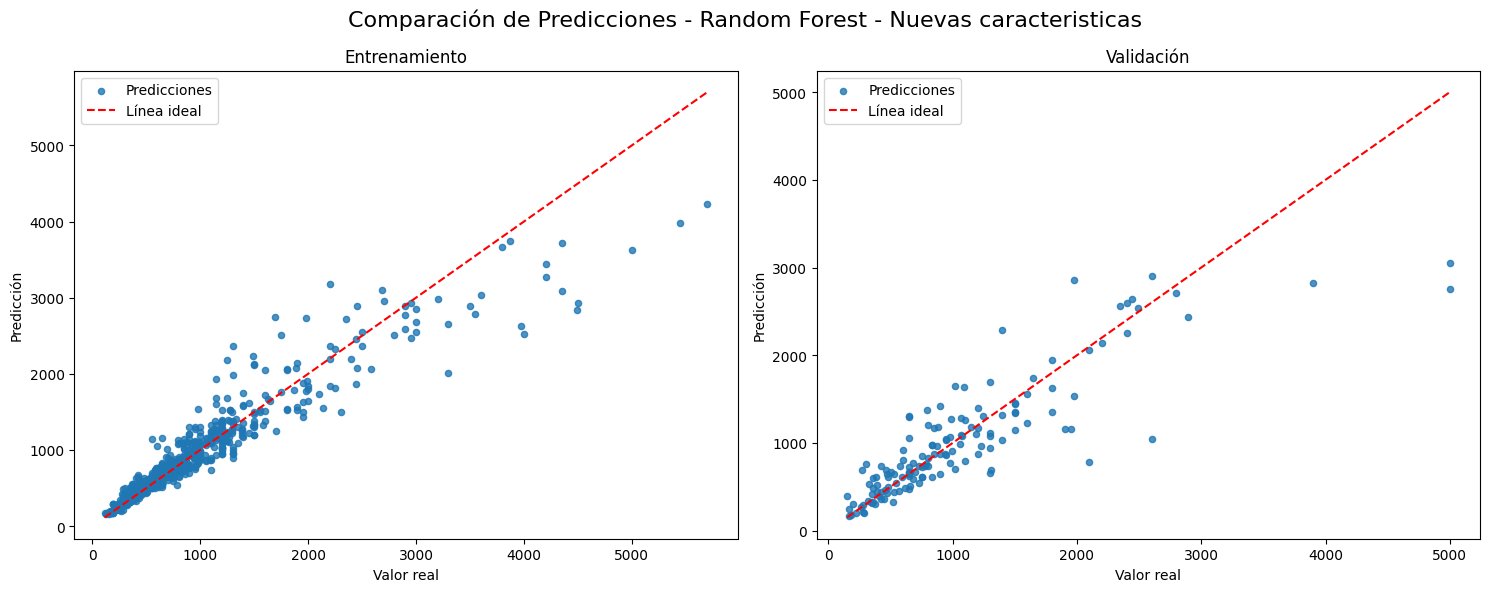

In [56]:
model_evaluation(model_forest, df_train_new_features, df_valid_new_features, 'Random Forest - Nuevas caracteristicas')

### XGBoost

In [57]:
model_xgb = xgb.XGBRegressor(eval_metric='rmse',
                            learning_rate = 0.04, 
                            max_depth=6, 
                            subsample=0.9,
                            colsample_bytree=0.9,
                            n_estimators=70,
                            alpha=0.2,
                            random_state=ran)

📊 Evaluación del modelo: XGBoost
Dataset de Entrenamiento
RMSE: 190.48
MAE: 124.63
Dataset de Validación
RMSE: 464.67
MAE: 263.15


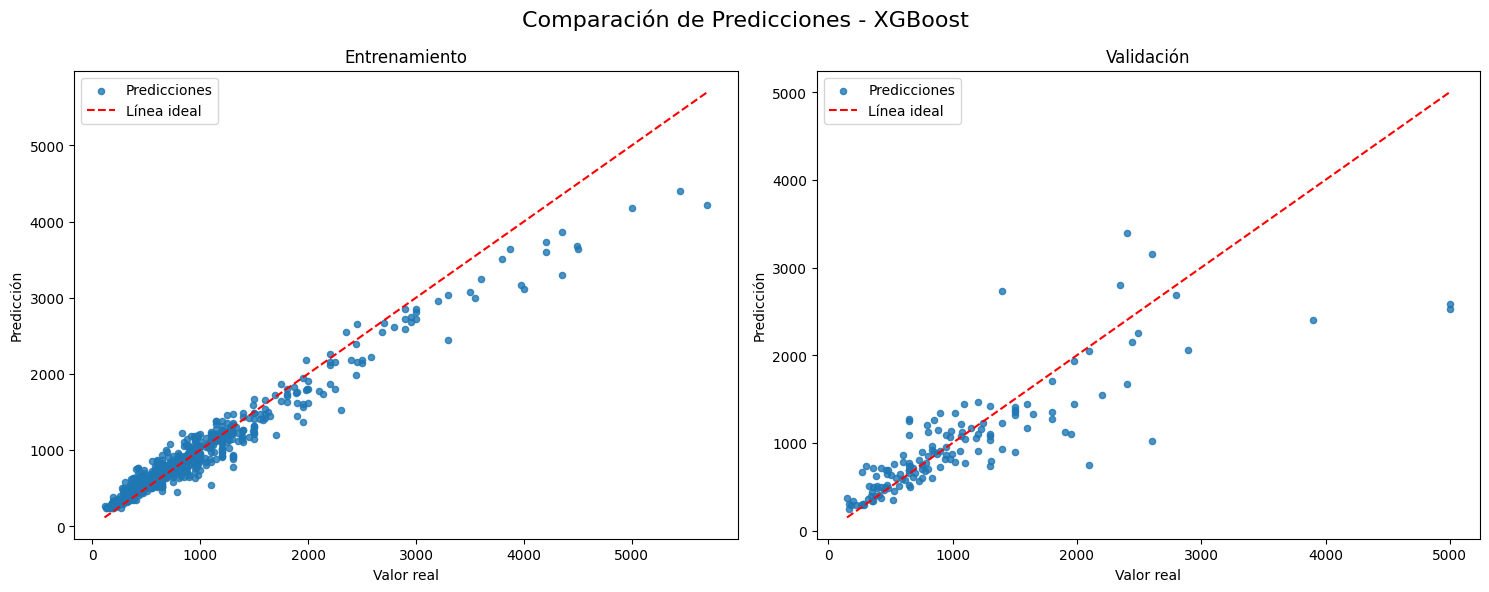

In [58]:
model_evaluation(model_xgb, df_train, df_valid, 'XGBoost')

📊 Evaluación del modelo: XGBoost - Forest Isolation
Dataset de Entrenamiento
RMSE: 157.61
MAE: 106.66
Dataset de Validación
RMSE: 315.72
MAE: 208.44


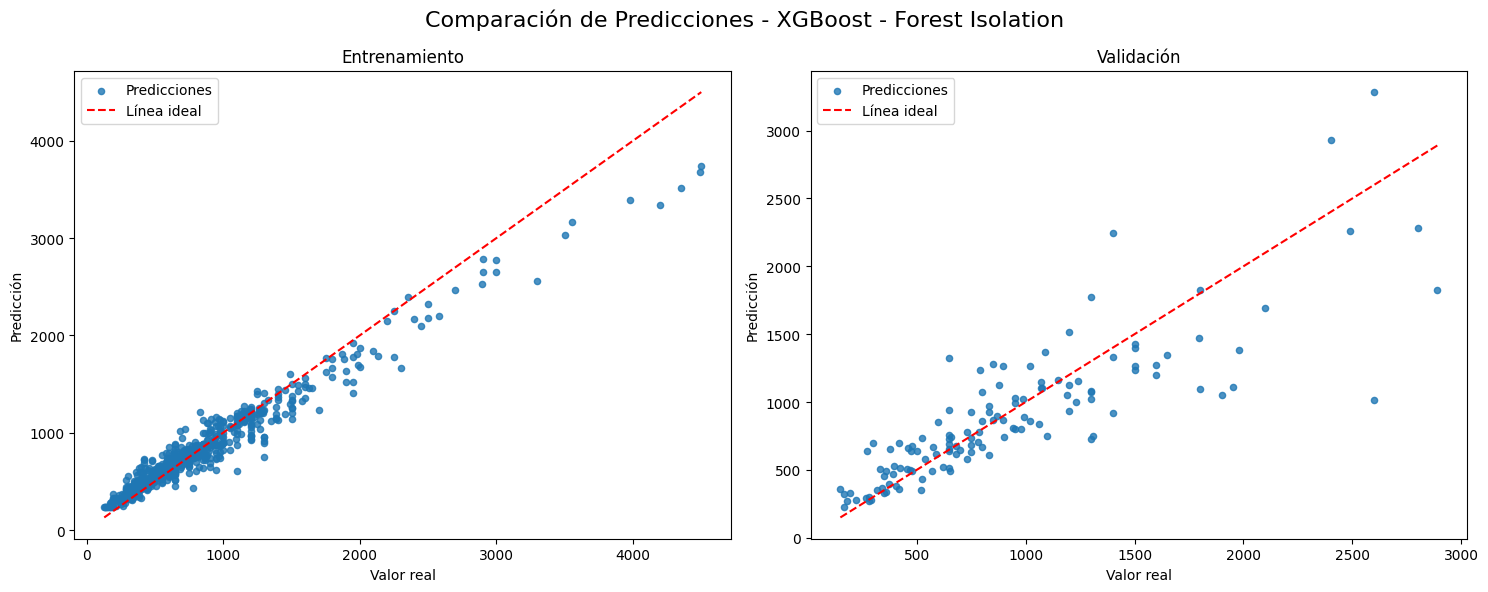

In [59]:
model_evaluation(model_xgb, df_train_isolation, df_valid_isolation, 'XGBoost - Forest Isolation')

📊 Evaluación del modelo: XG-Boost - DF escalado
Dataset de Entrenamiento
RMSE: 190.48
MAE: 124.63
Dataset de Validación
RMSE: 464.67
MAE: 263.15


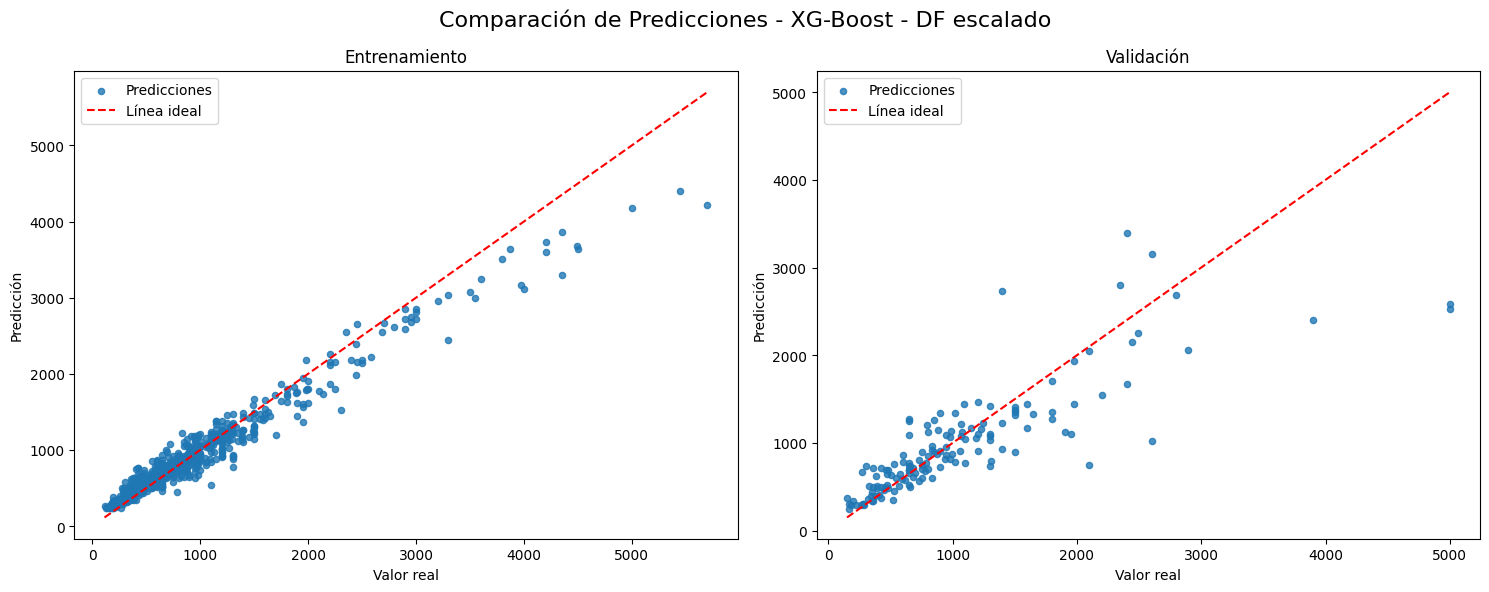

In [60]:
model_evaluation(model_xgb, df_train_scaled, df_valid_scaled, 'XG-Boost - DF escalado')

📊 Evaluación del modelo: XG-Boost - Cluster
Dataset de Entrenamiento
RMSE: 140.63
MAE: 94.68
Dataset de Validación
RMSE: 359.10
MAE: 226.00


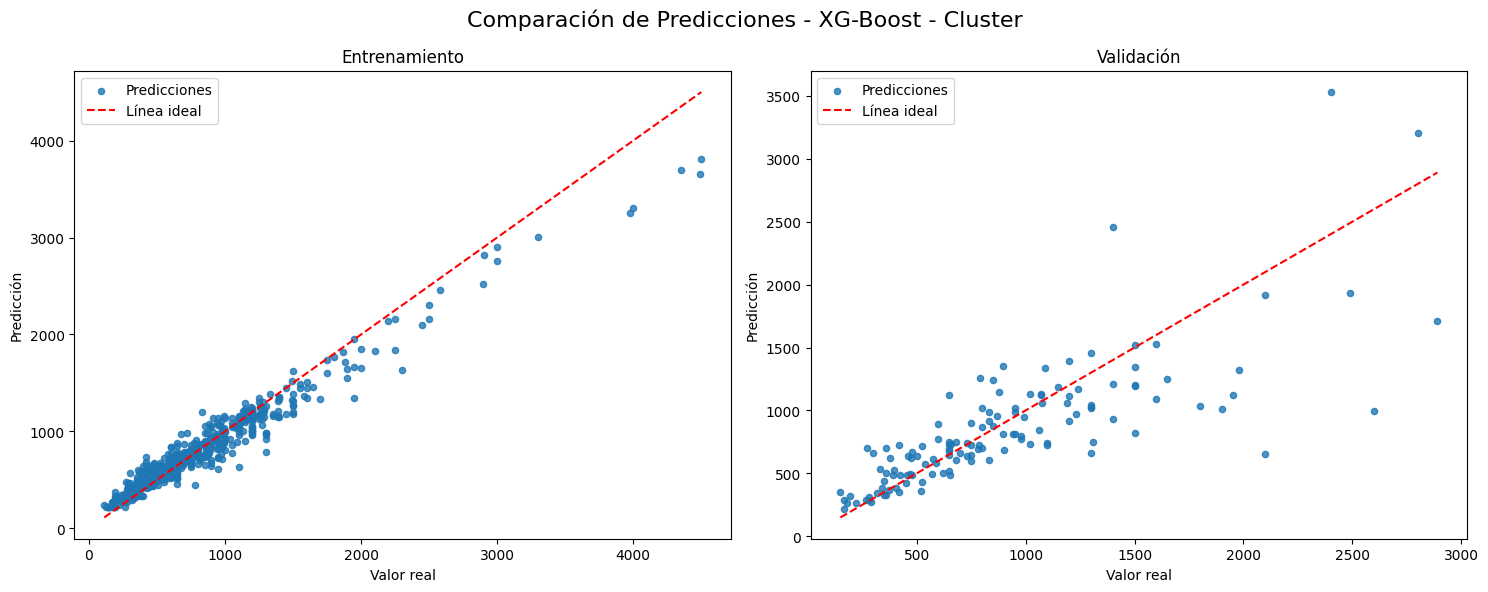

In [61]:
model_evaluation(model_xgb, df_train_cluster, df_valid_cluster, 'XG-Boost - Cluster')

📊 Evaluación del modelo: XG-Boost - Selected features
Dataset de Entrenamiento
RMSE: 207.82
MAE: 135.98
Dataset de Validación
RMSE: 442.41
MAE: 252.14


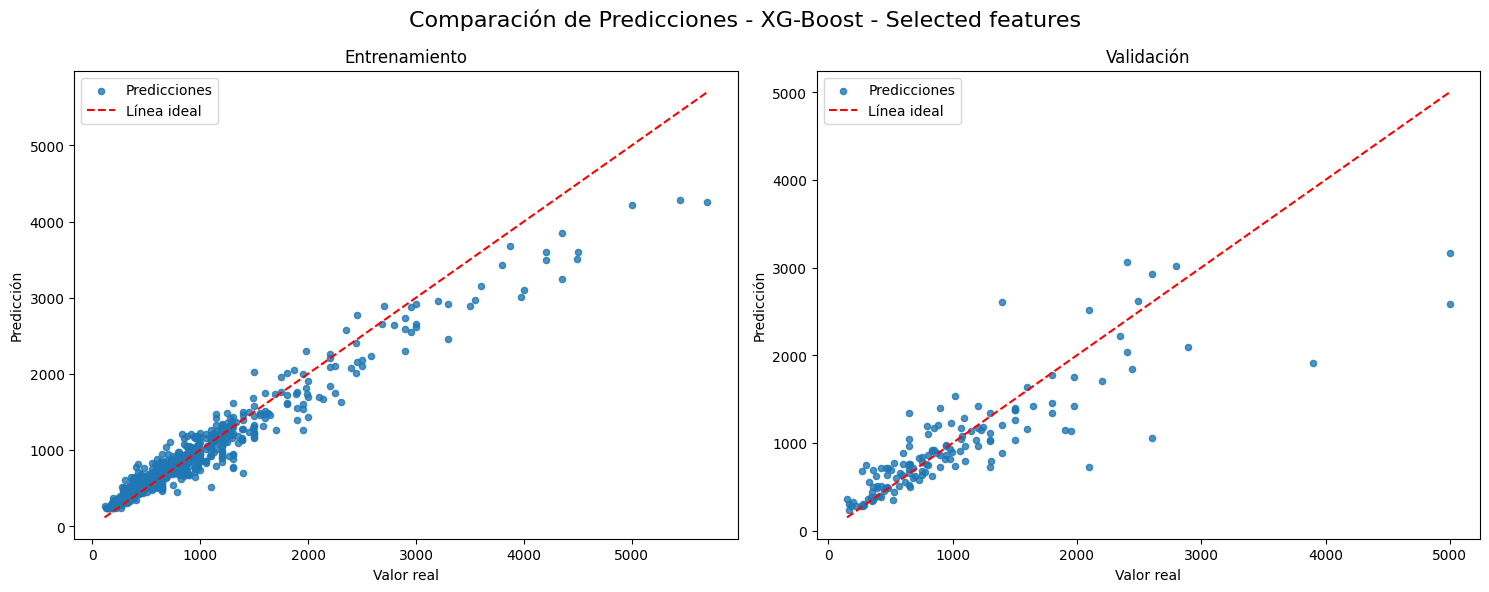

In [62]:
model_evaluation(model_xgb, df_train_selected_features, df_valid_selected_features, 'XG-Boost - Selected features')

📊 Evaluación del modelo: XG-Boost - OHE stratum
Dataset de Entrenamiento
RMSE: 212.87
MAE: 139.78
Dataset de Validación
RMSE: 466.08
MAE: 276.69


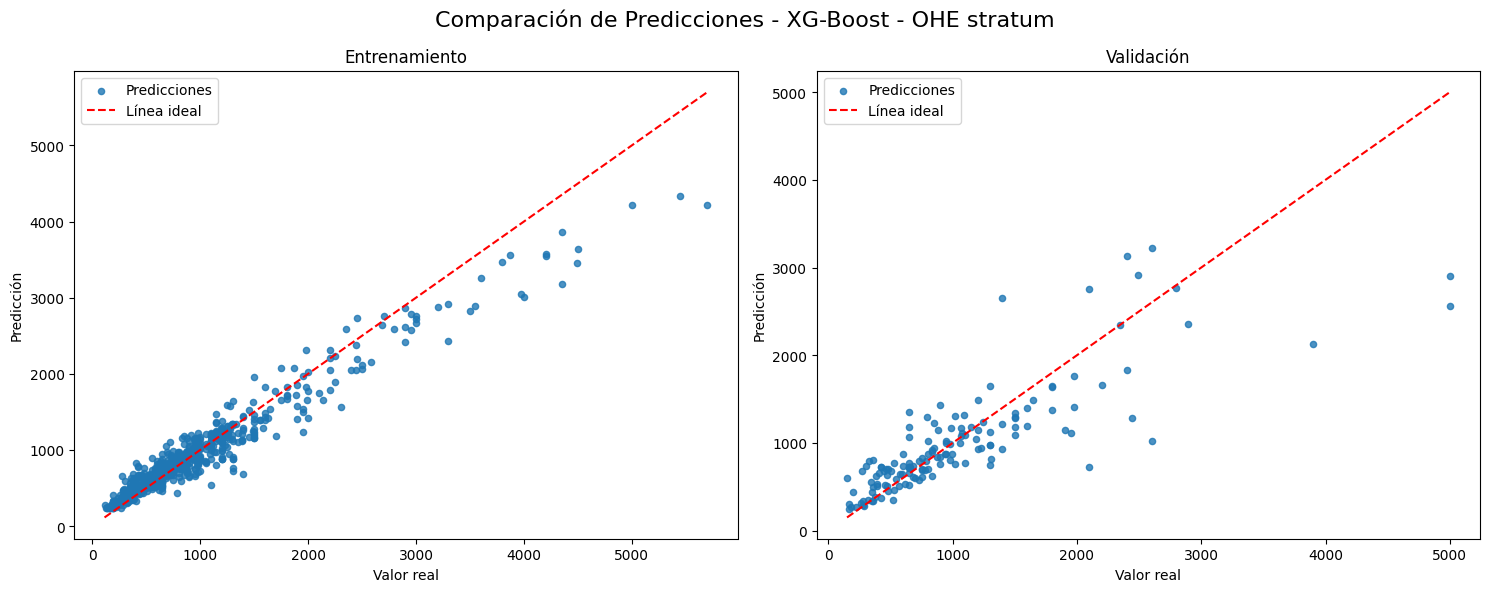

In [63]:
model_evaluation(model_xgb, df_train_ohe, df_valid_ohe, 'XG-Boost - OHE stratum')

📊 Evaluación del modelo: XGBoost - Nuevas caracteristicas
Dataset de Entrenamiento
RMSE: 174.43
MAE: 116.23
Dataset de Validación
RMSE: 477.84
MAE: 275.04


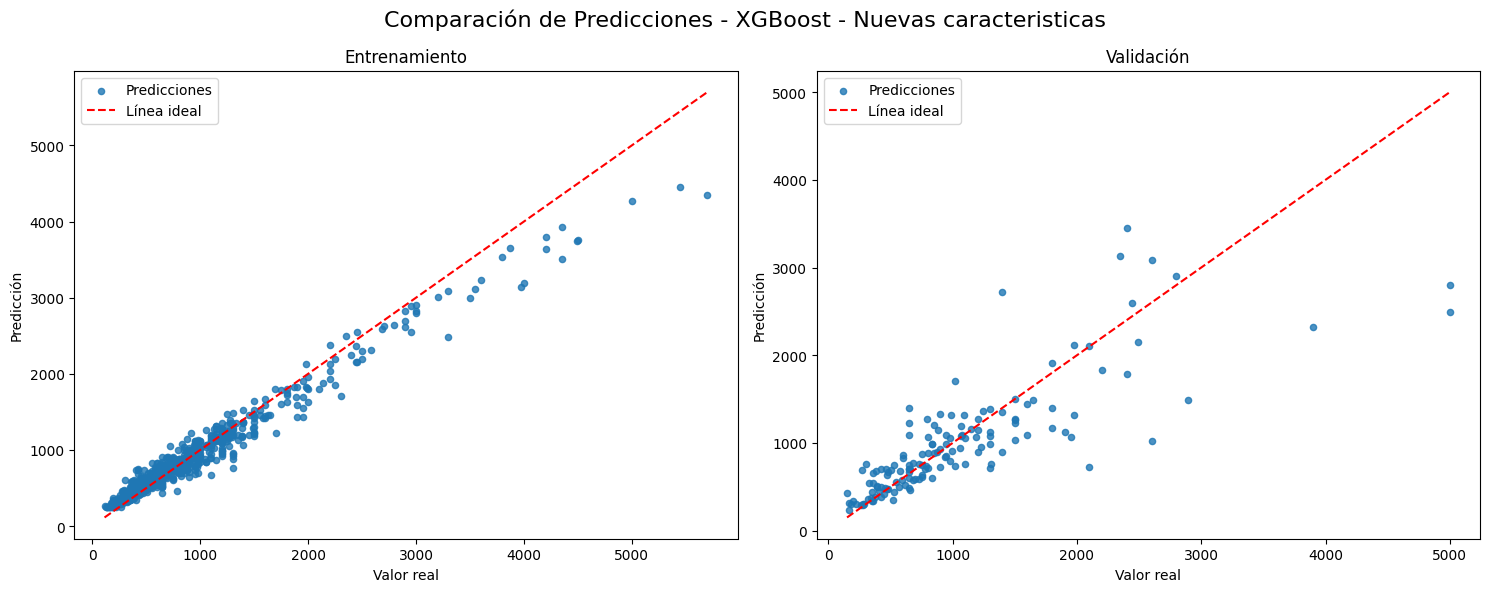

In [64]:
model_evaluation(model_xgb, df_train_new_features, df_valid_new_features, 'XGBoost - Nuevas caracteristicas')

## Optimizacion

In [65]:
model_xgb_selected = xgb.XGBRegressor(random_state=ran)
params = {
    'learning_rate'     : [0.01, 0.04, 0.08], 
    'max_depth'         : [3, 6, 12], 
    'subsample'         : [0.5, 0.9],
    'colsample_bytree'  : [0.5, 0.9],
    'n_estimators'      : [50, 70, 100],
    'alpha'             : [0.2, 1],
}
grid_search = GridSearchCV(estimator=model_xgb_selected,
                           param_grid=params,
                           verbose=3,
                           scoring= 'neg_mean_absolute_error', 
                           cv=3,)

In [66]:
df_opt = pd.concat([df_train_new_features_removed, df_valid_new_features_removed], axis=0)
f_opt_nf, t_opt_nf = features_target_split(df_opt)

In [67]:
grid_search.fit(f_opt_nf, t_opt_nf)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END alpha=0.2, colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5;, score=-394.021 total time=   0.0s
[CV 2/3] END alpha=0.2, colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5;, score=-404.964 total time=   0.0s
[CV 3/3] END alpha=0.2, colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5;, score=-416.382 total time=   0.0s
[CV 1/3] END alpha=0.2, colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9;, score=-392.703 total time=   0.0s
[CV 2/3] END alpha=0.2, colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9;, score=-404.052 total time=   0.0s
[CV 3/3] END alpha=0.2, colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9;, score=-412.923 total time=   0.0s
[CV 1/3] END alpha=0.2, colsample_bytree=0.5, learning_rate=0

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'alpha': [0.2, 1], 'colsample_bytree': [0.5, 0.9],
                         'learning_rate': [0.01, 0.04, 0.08],
                         'max_depth': [3, 6, 12], 'n_estimators': [50, 70, 100],
                         'subsample': [0.5, 0.9]},
             scoring='neg_mean_absolute_error', verbose=3)

In [68]:
best_xgb = grid_search.best_estimator_
grid_search.best_params_

{'alpha': 0.2,
 'colsample_bytree': 0.5,
 'learning_rate': 0.04,
 'max_depth': 6,
 'n_estimators': 100,
 'subsample': 0.5}

📊 Evaluación del modelo: XGBoost - Nuevas caracteristicas
Dataset de Entrenamiento
RMSE: 218.77
MAE: 136.09
Dataset de Validación
RMSE: 432.53
MAE: 250.62


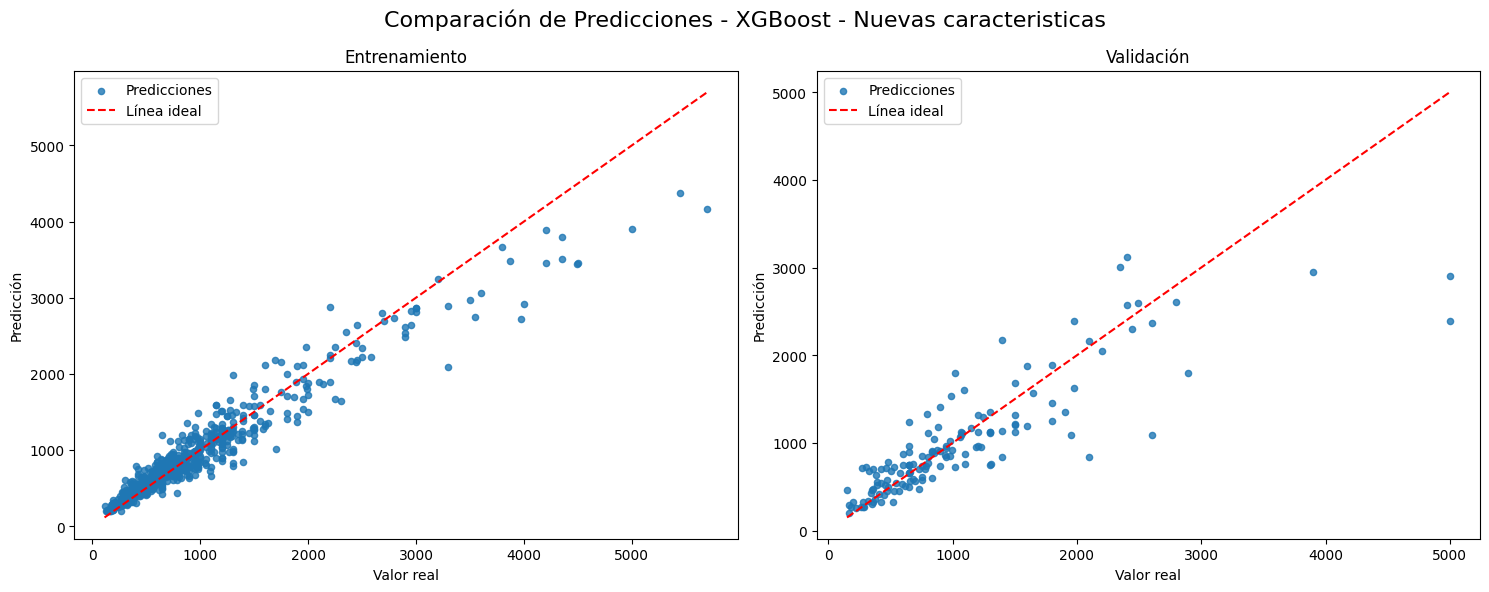

In [69]:
model_evaluation(best_xgb, df_train_new_features_removed, df_valid_new_features_removed, 'XGBoost - Nuevas caracteristicas')

## Prueba con datos de test

📊 Evaluación del modelo: XGBoost - Nuevas caracteristicas
Dataset de Entrenamiento
RMSE: 218.77
MAE: 136.09
Dataset de Validación
RMSE: 443.44
MAE: 269.57


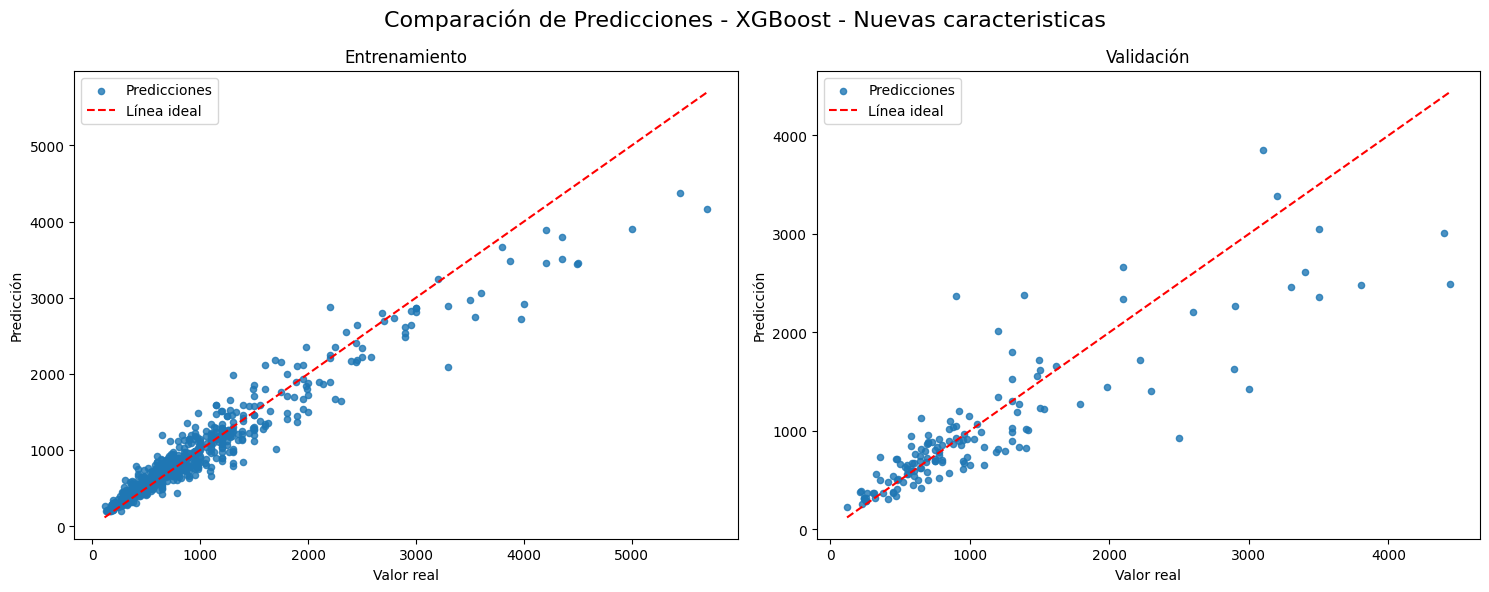

In [70]:
model_evaluation(best_xgb, df_train_new_features_removed, df_test_new_features_removed, 'XGBoost - Nuevas caracteristicas')

In [71]:
sample = df_test_new_features_removed.sample(10, random_state=112)
f_test, t_test = features_target_split(sample)
predictions_test = best_xgb.predict(f_test)

data_prediction_sample = {
    'real': sample['fixed_price'],
    'prediction': predictions_test,
    'residual': predictions_test - sample['fixed_price']
}
answer = pd.DataFrame(data_prediction_sample)
answer

,real,prediction,residual
675,220.0,392.300049,172.300049
398,680.0,794.203247,114.203247
289,3500.0,2355.485596,-1144.514404
466,2100.0,2334.961914,234.961914
831,305.0,373.343658,68.343658
167,957.0,673.980347,-283.019653
455,580.0,849.166687,269.166687
349,1300.0,894.636719,-405.363281
395,642.0,743.144714,101.144714
919,120.0,226.580048,106.580048
